
    Target :
        Add regularization to overfit model
    Results:
        Parameters: 9,752
        Best Train Accuracy: 98.4 (17th Epoch)
        Best Train Accuracy: 99.44 (14th Epoch)
    Analysis:
        Does well with L1 and L2.
        No overfitting.
        Less Consistent with Target.
        
        
        
        


# Import Libraries

In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 


In [0]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                       #transforms.Resize((28, 28)),
                                       transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                       #transforms.RandomAffine((-7.0, 7.0)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [0]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

# Dataloader Arguments & Test/Train Dataloaders


In [5]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


# The model
Let's start with the model we first saw

In [0]:
# Experiment-1 Reducing Parameters (set the model right). Impact: Parameters gone down/ no overfit/ low accuracy
# Experiment-2 Re-Structuring model looking at the receptive field. Impact: Parameters gone down further/ no overfit/ low accuracy
# Experiment-3 Adding BatchNorm to bump up the accuracy . Impact: limited parameters/ Overfitting/ accuracy improved
# Experiment-4 Adding Dropout to regularize. Impact: limited parameters/ no overfit/ test accuracy consistent
# Experiment-5 Restructuring model with GAP at the end of the convolutions. limited parameters/ underfit / no target acc
# Experiment-6 Reducing Dropout value to 10% as in experiment-5 it was highly penalized. Adding many transforms
# Experiment-7 Playing with LR Scheduler
dropout_value = 0.1
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.Dropout2d(dropout_value)
        ) #input:28x28 Output:26x26 RF:3x3
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout2d(dropout_value)
        ) #input:26x26 Output:24x24 RF:5x5

          ######################### TRANSITION BLOCK 1 ############################
        self.pool1 = nn.MaxPool2d(2, 2) #input:24x24 Output:12x12 RF:6x6

        self.conv_1x1_1 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=8, kernel_size=(1, 1), padding=0, bias=False),
            
        ) #input:13x13 Output:12x12 RF:6x6

        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout2d(dropout_value)
        ) #input:12x12 Output:10x10 RF:10x10

        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout2d(dropout_value)
        ) #input:10x10 Output:8x8 RF:14x14

        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout2d(dropout_value)
        ) #input:10x10 Output:8x8 RF:18x18

        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout2d(dropout_value)
        ) #input:8x8 Output:6x6 RF:22x22

         ######################### TRANSITION BLOCK 2 ############################
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=6)
        ) #input:6x6 Output:1x1 RF:32x32

        self.conv_1x1_2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1,1), padding=0, bias=False)
        )
    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.conv_1x1_1(x)
        x = self.pool1(x)
        x = self.convblock3(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.gap(x)
        x = self.conv_1x1_2(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Model Params
Can't emphasize on how important viewing Model Summary is. 
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [7]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
              ReLU-2            [-1, 8, 26, 26]               0
       BatchNorm2d-3            [-1, 8, 26, 26]              16
         Dropout2d-4            [-1, 8, 26, 26]               0
            Conv2d-5           [-1, 16, 24, 24]           1,152
              ReLU-6           [-1, 16, 24, 24]               0
       BatchNorm2d-7           [-1, 16, 24, 24]              32
         Dropout2d-8           [-1, 16, 24, 24]               0
            Conv2d-9            [-1, 8, 24, 24]             128
        MaxPool2d-10            [-1, 8, 12, 12]               0
           Conv2d-11           [-1, 16, 10, 10]           1,152
             ReLU-12           [-1, 16, 10, 10]               0
      BatchNorm2d-13           [-1, 16, 10, 10]              32
        Dropout2d-14           [-1

# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions

In [0]:
from tqdm import tqdm

train_losses = []
train_losses_l1 = []
train_losses_l2 = []
train_losses_l1_l2 = []
test_losses = []
test_losses_l1 = []
test_losses_l2 = []
test_losses_l1_l2 = []
train_acc = []
train_acc_l1 = []
train_acc_l2 = []
train_acc_l1_l2 = []
test_acc = []
test_acc_l1 = []
test_acc_l2 = []
test_acc_l1_l2 = []

def train(model, device, train_loader, optimizer, epoch, reg_type):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    
    # Calculate Loss after adding Lasso to the total loss calculated
    l1_loss_magnitude = 0
    if reg_type == 'l1' or reg_type == 'l1l2':
      for param in model.parameters():
        l1_loss_magnitude = l1_loss_magnitude + torch.sum(torch.abs(param))

    l1_loss = float(0.00003) * l1_loss_magnitude
    #print("L1 (Lasso) is calculated as {} ".format(l1_loss))

    # Adding regularization to the loss incurred
    loss = loss + l1_loss

    #Conditional for regularizationb type
    if reg_type == 'l1':
      train_losses_l1.append(loss)
    elif reg_type == 'l2':
      train_losses_l2.append(loss)
    elif reg_type == 'l1l2':
      train_losses_l1_l2.append(loss)
    else:
      train_losses.append(loss)
    
    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader, reg_type):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()


    test_loss /= len(test_loader.dataset)

    #Conditional for regularizationb type
    if reg_type == 'l1':
      test_losses_l1.append(test_loss)
      test_acc_l1.append(100. * correct / len(test_loader.dataset))
    elif reg_type == 'l2':
      test_losses_l2.append(test_loss)
      test_acc_l2.append(100. * correct / len(test_loader.dataset))
    elif reg_type == 'l1l2':
      test_losses_l1_l2.append(test_loss)
      test_acc_l1_l2.append(100. * correct / len(test_loader.dataset))
    else:
      test_losses.append(test_loss)
      test_acc.append(100. * correct / len(test_loader.dataset))

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
                            
    
    

# Let's Train and test our model

In [9]:
# 0.0015 Best Test Acc - 99.09
# 0.003 Best Test Acc - 98.94
# 0.0001 Best Test Acc - 99.5
from torch.optim.lr_scheduler import StepLR
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.03, momentum=0.9)
optimizer_l1 = optim.SGD(model.parameters(), lr=0.03, momentum=0.9)
optimizer_l2 = optim.SGD(model.parameters(), lr=0.03, momentum=0.9, weight_decay=0.0003)
optimizer_l1_l2 = optim.SGD(model.parameters(), lr=0.03, momentum=0.9, weight_decay=0.0003)
#lrscheduler = StepLR(optimizer, step_size=6, gamma=0.1)
EPOCHS = 40
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch, None)
    test(model, device, test_loader, None)

for epoch in range(EPOCHS):
    print("EPOCH_L1:", epoch)
    train(model, device, train_loader, optimizer_l1, epoch, 'l1')
    test(model, device, test_loader, 'l1')

for epoch in range(EPOCHS):
    print("EPOCH_L2:", epoch)
    train(model, device, train_loader, optimizer_l2, epoch, 'l2')
    test(model, device, test_loader, 'l2')

for epoch in range(EPOCHS):
    print("EPOCH_L1_L2:", epoch)
    train(model, device, train_loader, optimizer_l1_l2, epoch, 'l1l2')
    test(model, device, test_loader, 'l1l2')

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


Loss=0.18869532644748688 Batch_id=468 Accuracy=87.51: 100%|██████████| 469/469 [00:22<00:00, 20.99it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0627, Accuracy: 9814/10000 (98.14%)

EPOCH: 1


Loss=0.1484033316373825 Batch_id=468 Accuracy=96.19: 100%|██████████| 469/469 [00:22<00:00, 20.96it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0447, Accuracy: 9858/10000 (98.58%)

EPOCH: 2


Loss=0.021485120058059692 Batch_id=468 Accuracy=96.86: 100%|██████████| 469/469 [00:22<00:00, 21.02it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0358, Accuracy: 9893/10000 (98.93%)

EPOCH: 3


Loss=0.05653773248195648 Batch_id=468 Accuracy=97.19: 100%|██████████| 469/469 [00:22<00:00, 26.83it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0318, Accuracy: 9894/10000 (98.94%)

EPOCH: 4


Loss=0.06782660633325577 Batch_id=468 Accuracy=97.54: 100%|██████████| 469/469 [00:22<00:00, 25.49it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0264, Accuracy: 9917/10000 (99.17%)

EPOCH: 5


Loss=0.1027008667588234 Batch_id=468 Accuracy=97.80: 100%|██████████| 469/469 [00:22<00:00, 21.00it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0286, Accuracy: 9908/10000 (99.08%)

EPOCH: 6


Loss=0.06661229580640793 Batch_id=468 Accuracy=97.80: 100%|██████████| 469/469 [00:21<00:00, 21.45it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0260, Accuracy: 9918/10000 (99.18%)

EPOCH: 7


Loss=0.02351474203169346 Batch_id=468 Accuracy=97.92: 100%|██████████| 469/469 [00:21<00:00, 27.30it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0248, Accuracy: 9921/10000 (99.21%)

EPOCH: 8


Loss=0.13358698785305023 Batch_id=468 Accuracy=97.95: 100%|██████████| 469/469 [00:21<00:00, 21.58it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0258, Accuracy: 9923/10000 (99.23%)

EPOCH: 9


Loss=0.052954550832509995 Batch_id=468 Accuracy=98.03: 100%|██████████| 469/469 [00:21<00:00, 21.42it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0230, Accuracy: 9925/10000 (99.25%)

EPOCH: 10


Loss=0.03139268979430199 Batch_id=468 Accuracy=98.15: 100%|██████████| 469/469 [00:21<00:00, 21.64it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0207, Accuracy: 9930/10000 (99.30%)

EPOCH: 11


Loss=0.06267812103033066 Batch_id=468 Accuracy=98.14: 100%|██████████| 469/469 [00:21<00:00, 21.57it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0223, Accuracy: 9941/10000 (99.41%)

EPOCH: 12


Loss=0.06615500897169113 Batch_id=468 Accuracy=98.22: 100%|██████████| 469/469 [00:21<00:00, 21.63it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0205, Accuracy: 9939/10000 (99.39%)

EPOCH: 13


Loss=0.025322115048766136 Batch_id=468 Accuracy=98.25: 100%|██████████| 469/469 [00:21<00:00, 21.66it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0233, Accuracy: 9930/10000 (99.30%)

EPOCH: 14


Loss=0.019734442234039307 Batch_id=468 Accuracy=98.14: 100%|██████████| 469/469 [00:21<00:00, 21.84it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0227, Accuracy: 9932/10000 (99.32%)

EPOCH: 15


Loss=0.09567034244537354 Batch_id=468 Accuracy=98.27: 100%|██████████| 469/469 [00:21<00:00, 21.48it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0223, Accuracy: 9925/10000 (99.25%)

EPOCH: 16


Loss=0.02794998325407505 Batch_id=468 Accuracy=98.31: 100%|██████████| 469/469 [00:21<00:00, 21.83it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0183, Accuracy: 9943/10000 (99.43%)

EPOCH: 17


Loss=0.09252969175577164 Batch_id=468 Accuracy=98.40: 100%|██████████| 469/469 [00:21<00:00, 21.73it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0199, Accuracy: 9937/10000 (99.37%)

EPOCH: 18


Loss=0.05756488814949989 Batch_id=468 Accuracy=98.37: 100%|██████████| 469/469 [00:21<00:00, 21.86it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0209, Accuracy: 9938/10000 (99.38%)

EPOCH: 19


Loss=0.02199695073068142 Batch_id=468 Accuracy=98.38: 100%|██████████| 469/469 [00:21<00:00, 22.08it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0186, Accuracy: 9948/10000 (99.48%)

EPOCH: 20


Loss=0.047703180462121964 Batch_id=468 Accuracy=98.37: 100%|██████████| 469/469 [00:21<00:00, 21.74it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0199, Accuracy: 9942/10000 (99.42%)

EPOCH: 21


Loss=0.0899667739868164 Batch_id=468 Accuracy=98.50: 100%|██████████| 469/469 [00:21<00:00, 22.03it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0198, Accuracy: 9939/10000 (99.39%)

EPOCH: 22


Loss=0.07378026098012924 Batch_id=468 Accuracy=98.43: 100%|██████████| 469/469 [00:21<00:00, 21.64it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0195, Accuracy: 9936/10000 (99.36%)

EPOCH: 23


Loss=0.04094420745968819 Batch_id=468 Accuracy=98.54: 100%|██████████| 469/469 [00:21<00:00, 21.76it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0215, Accuracy: 9931/10000 (99.31%)

EPOCH: 24


Loss=0.019636929035186768 Batch_id=468 Accuracy=98.52: 100%|██████████| 469/469 [00:21<00:00, 21.96it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0186, Accuracy: 9945/10000 (99.45%)

EPOCH: 25


Loss=0.051674842834472656 Batch_id=468 Accuracy=98.48: 100%|██████████| 469/469 [00:21<00:00, 21.69it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0187, Accuracy: 9941/10000 (99.41%)

EPOCH: 26


Loss=0.08724067360162735 Batch_id=468 Accuracy=98.47: 100%|██████████| 469/469 [00:21<00:00, 26.40it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0185, Accuracy: 9948/10000 (99.48%)

EPOCH: 27


Loss=0.026659302413463593 Batch_id=468 Accuracy=98.52: 100%|██████████| 469/469 [00:21<00:00, 21.76it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0179, Accuracy: 9947/10000 (99.47%)

EPOCH: 28


Loss=0.02073938585817814 Batch_id=468 Accuracy=98.58: 100%|██████████| 469/469 [00:21<00:00, 21.67it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0198, Accuracy: 9943/10000 (99.43%)

EPOCH: 29


Loss=0.02044970728456974 Batch_id=468 Accuracy=98.54: 100%|██████████| 469/469 [00:21<00:00, 22.24it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0187, Accuracy: 9941/10000 (99.41%)

EPOCH: 30


Loss=0.027791345492005348 Batch_id=468 Accuracy=98.61: 100%|██████████| 469/469 [00:21<00:00, 22.13it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0194, Accuracy: 9946/10000 (99.46%)

EPOCH: 31


Loss=0.11174134165048599 Batch_id=468 Accuracy=98.60: 100%|██████████| 469/469 [00:21<00:00, 22.17it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0180, Accuracy: 9943/10000 (99.43%)

EPOCH: 32


Loss=0.021346962079405785 Batch_id=468 Accuracy=98.57: 100%|██████████| 469/469 [00:21<00:00, 22.21it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0199, Accuracy: 9940/10000 (99.40%)

EPOCH: 33


Loss=0.060792114585638046 Batch_id=468 Accuracy=98.58: 100%|██████████| 469/469 [00:21<00:00, 21.79it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0183, Accuracy: 9948/10000 (99.48%)

EPOCH: 34


Loss=0.05594195798039436 Batch_id=468 Accuracy=98.57: 100%|██████████| 469/469 [00:21<00:00, 21.74it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0168, Accuracy: 9954/10000 (99.54%)

EPOCH: 35


Loss=0.030910953879356384 Batch_id=468 Accuracy=98.62: 100%|██████████| 469/469 [00:21<00:00, 21.62it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0193, Accuracy: 9945/10000 (99.45%)

EPOCH: 36


Loss=0.018497982993721962 Batch_id=468 Accuracy=98.62: 100%|██████████| 469/469 [00:21<00:00, 21.60it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0183, Accuracy: 9949/10000 (99.49%)

EPOCH: 37


Loss=0.03868340328335762 Batch_id=468 Accuracy=98.61: 100%|██████████| 469/469 [00:21<00:00, 21.95it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0176, Accuracy: 9949/10000 (99.49%)

EPOCH: 38


Loss=0.05124063789844513 Batch_id=468 Accuracy=98.64: 100%|██████████| 469/469 [00:21<00:00, 21.86it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0189, Accuracy: 9947/10000 (99.47%)

EPOCH: 39


Loss=0.046210113912820816 Batch_id=468 Accuracy=98.60: 100%|██████████| 469/469 [00:21<00:00, 21.56it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0168, Accuracy: 9956/10000 (99.56%)

EPOCH_L1: 0


Loss=0.1382991224527359 Batch_id=468 Accuracy=98.73: 100%|██████████| 469/469 [00:22<00:00, 21.21it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0173, Accuracy: 9951/10000 (99.51%)

EPOCH_L1: 1


Loss=0.07310281693935394 Batch_id=468 Accuracy=98.69: 100%|██████████| 469/469 [00:22<00:00, 20.73it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0186, Accuracy: 9946/10000 (99.46%)

EPOCH_L1: 2


Loss=0.0882270336151123 Batch_id=468 Accuracy=98.67: 100%|██████████| 469/469 [00:22<00:00, 21.19it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0177, Accuracy: 9945/10000 (99.45%)

EPOCH_L1: 3


Loss=0.18378828465938568 Batch_id=468 Accuracy=98.68: 100%|██████████| 469/469 [00:21<00:00, 21.54it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0175, Accuracy: 9948/10000 (99.48%)

EPOCH_L1: 4


Loss=0.055319610983133316 Batch_id=468 Accuracy=98.70: 100%|██████████| 469/469 [00:21<00:00, 21.69it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0187, Accuracy: 9951/10000 (99.51%)

EPOCH_L1: 5


Loss=0.11275258660316467 Batch_id=468 Accuracy=98.69: 100%|██████████| 469/469 [00:21<00:00, 21.88it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0183, Accuracy: 9945/10000 (99.45%)

EPOCH_L1: 6


Loss=0.06121453270316124 Batch_id=468 Accuracy=98.73: 100%|██████████| 469/469 [00:22<00:00, 21.32it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0189, Accuracy: 9944/10000 (99.44%)

EPOCH_L1: 7


Loss=0.08033404499292374 Batch_id=468 Accuracy=98.61: 100%|██████████| 469/469 [00:21<00:00, 21.78it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0187, Accuracy: 9944/10000 (99.44%)

EPOCH_L1: 8


Loss=0.09300277382135391 Batch_id=468 Accuracy=98.72: 100%|██████████| 469/469 [00:21<00:00, 21.68it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0167, Accuracy: 9949/10000 (99.49%)

EPOCH_L1: 9


Loss=0.061188001185655594 Batch_id=468 Accuracy=98.55: 100%|██████████| 469/469 [00:22<00:00, 28.09it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0177, Accuracy: 9954/10000 (99.54%)

EPOCH_L1: 10


Loss=0.08790920674800873 Batch_id=468 Accuracy=98.67: 100%|██████████| 469/469 [00:21<00:00, 21.93it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0173, Accuracy: 9951/10000 (99.51%)

EPOCH_L1: 11


Loss=0.14486177265644073 Batch_id=468 Accuracy=98.61: 100%|██████████| 469/469 [00:21<00:00, 21.67it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0190, Accuracy: 9944/10000 (99.44%)

EPOCH_L1: 12


Loss=0.1453143209218979 Batch_id=468 Accuracy=98.61: 100%|██████████| 469/469 [00:21<00:00, 21.81it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0171, Accuracy: 9952/10000 (99.52%)

EPOCH_L1: 13


Loss=0.06300551444292068 Batch_id=468 Accuracy=98.62: 100%|██████████| 469/469 [00:21<00:00, 21.65it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0177, Accuracy: 9944/10000 (99.44%)

EPOCH_L1: 14


Loss=0.05421867221593857 Batch_id=468 Accuracy=98.65: 100%|██████████| 469/469 [00:21<00:00, 21.79it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0183, Accuracy: 9948/10000 (99.48%)

EPOCH_L1: 15


Loss=0.0553232878446579 Batch_id=468 Accuracy=98.62: 100%|██████████| 469/469 [00:21<00:00, 21.97it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0194, Accuracy: 9939/10000 (99.39%)

EPOCH_L1: 16


Loss=0.11572560667991638 Batch_id=468 Accuracy=98.62: 100%|██████████| 469/469 [00:21<00:00, 21.65it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0174, Accuracy: 9947/10000 (99.47%)

EPOCH_L1: 17


Loss=0.10285221040248871 Batch_id=468 Accuracy=98.73: 100%|██████████| 469/469 [00:21<00:00, 21.65it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0178, Accuracy: 9949/10000 (99.49%)

EPOCH_L1: 18


Loss=0.11056847870349884 Batch_id=468 Accuracy=98.67: 100%|██████████| 469/469 [00:21<00:00, 21.94it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0175, Accuracy: 9948/10000 (99.48%)

EPOCH_L1: 19


Loss=0.0906725525856018 Batch_id=468 Accuracy=98.69: 100%|██████████| 469/469 [00:21<00:00, 21.69it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0174, Accuracy: 9944/10000 (99.44%)

EPOCH_L1: 20


Loss=0.07414297014474869 Batch_id=468 Accuracy=98.69: 100%|██████████| 469/469 [00:21<00:00, 21.67it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0181, Accuracy: 9942/10000 (99.42%)

EPOCH_L1: 21


Loss=0.06273997575044632 Batch_id=468 Accuracy=98.66: 100%|██████████| 469/469 [00:21<00:00, 21.81it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0172, Accuracy: 9954/10000 (99.54%)

EPOCH_L1: 22


Loss=0.1147288978099823 Batch_id=468 Accuracy=98.60: 100%|██████████| 469/469 [00:21<00:00, 21.50it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0173, Accuracy: 9951/10000 (99.51%)

EPOCH_L1: 23


Loss=0.13575851917266846 Batch_id=468 Accuracy=98.70: 100%|██████████| 469/469 [00:21<00:00, 21.41it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0176, Accuracy: 9947/10000 (99.47%)

EPOCH_L1: 24


Loss=0.0853380411863327 Batch_id=468 Accuracy=98.68: 100%|██████████| 469/469 [00:21<00:00, 21.43it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0173, Accuracy: 9952/10000 (99.52%)

EPOCH_L1: 25


Loss=0.09799617528915405 Batch_id=468 Accuracy=98.56: 100%|██████████| 469/469 [00:21<00:00, 21.69it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0177, Accuracy: 9951/10000 (99.51%)

EPOCH_L1: 26


Loss=0.15753348171710968 Batch_id=468 Accuracy=98.62: 100%|██████████| 469/469 [00:21<00:00, 21.58it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0192, Accuracy: 9947/10000 (99.47%)

EPOCH_L1: 27


Loss=0.07662041485309601 Batch_id=468 Accuracy=98.68: 100%|██████████| 469/469 [00:21<00:00, 21.49it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0202, Accuracy: 9940/10000 (99.40%)

EPOCH_L1: 28


Loss=0.06636615097522736 Batch_id=468 Accuracy=98.66: 100%|██████████| 469/469 [00:21<00:00, 21.65it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0181, Accuracy: 9955/10000 (99.55%)

EPOCH_L1: 29


Loss=0.07995614409446716 Batch_id=468 Accuracy=98.64: 100%|██████████| 469/469 [00:21<00:00, 21.62it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0172, Accuracy: 9947/10000 (99.47%)

EPOCH_L1: 30


Loss=0.07947786897420883 Batch_id=468 Accuracy=98.69: 100%|██████████| 469/469 [00:21<00:00, 21.81it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0187, Accuracy: 9949/10000 (99.49%)

EPOCH_L1: 31


Loss=0.10346359014511108 Batch_id=468 Accuracy=98.63: 100%|██████████| 469/469 [00:21<00:00, 22.02it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0171, Accuracy: 9951/10000 (99.51%)

EPOCH_L1: 32


Loss=0.11811351776123047 Batch_id=468 Accuracy=98.57: 100%|██████████| 469/469 [00:21<00:00, 21.82it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0178, Accuracy: 9946/10000 (99.46%)

EPOCH_L1: 33


Loss=0.1011604517698288 Batch_id=468 Accuracy=98.74: 100%|██████████| 469/469 [00:21<00:00, 21.64it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0159, Accuracy: 9952/10000 (99.52%)

EPOCH_L1: 34


Loss=0.06742393225431442 Batch_id=468 Accuracy=98.64: 100%|██████████| 469/469 [00:21<00:00, 21.45it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0177, Accuracy: 9951/10000 (99.51%)

EPOCH_L1: 35


Loss=0.04849855974316597 Batch_id=468 Accuracy=98.64: 100%|██████████| 469/469 [00:21<00:00, 21.36it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0168, Accuracy: 9950/10000 (99.50%)

EPOCH_L1: 36


Loss=0.1375213861465454 Batch_id=468 Accuracy=98.69: 100%|██████████| 469/469 [00:21<00:00, 21.42it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0175, Accuracy: 9946/10000 (99.46%)

EPOCH_L1: 37


Loss=0.08601827919483185 Batch_id=468 Accuracy=98.64: 100%|██████████| 469/469 [00:21<00:00, 21.43it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0168, Accuracy: 9957/10000 (99.57%)

EPOCH_L1: 38


Loss=0.10269433259963989 Batch_id=468 Accuracy=98.61: 100%|██████████| 469/469 [00:21<00:00, 21.94it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0173, Accuracy: 9948/10000 (99.48%)

EPOCH_L1: 39


Loss=0.06869897246360779 Batch_id=468 Accuracy=98.57: 100%|██████████| 469/469 [00:21<00:00, 22.30it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0184, Accuracy: 9950/10000 (99.50%)

EPOCH_L2: 0


Loss=0.03222835063934326 Batch_id=468 Accuracy=98.65: 100%|██████████| 469/469 [00:20<00:00, 22.85it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0178, Accuracy: 9951/10000 (99.51%)

EPOCH_L2: 1


Loss=0.029764264822006226 Batch_id=468 Accuracy=98.68: 100%|██████████| 469/469 [00:20<00:00, 23.10it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0175, Accuracy: 9940/10000 (99.40%)

EPOCH_L2: 2


Loss=0.019432103261351585 Batch_id=468 Accuracy=98.66: 100%|██████████| 469/469 [00:20<00:00, 22.69it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0184, Accuracy: 9944/10000 (99.44%)

EPOCH_L2: 3


Loss=0.04250633716583252 Batch_id=468 Accuracy=98.68: 100%|██████████| 469/469 [00:23<00:00, 27.24it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0179, Accuracy: 9948/10000 (99.48%)

EPOCH_L2: 4


Loss=0.10230471938848495 Batch_id=468 Accuracy=98.62: 100%|██████████| 469/469 [00:21<00:00, 21.76it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0184, Accuracy: 9947/10000 (99.47%)

EPOCH_L2: 5


Loss=0.03293482959270477 Batch_id=468 Accuracy=98.60: 100%|██████████| 469/469 [00:21<00:00, 21.94it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0176, Accuracy: 9952/10000 (99.52%)

EPOCH_L2: 6


Loss=0.06389475613832474 Batch_id=468 Accuracy=98.66: 100%|██████████| 469/469 [00:20<00:00, 28.08it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0174, Accuracy: 9944/10000 (99.44%)

EPOCH_L2: 7


Loss=0.07648705691099167 Batch_id=468 Accuracy=98.61: 100%|██████████| 469/469 [00:21<00:00, 21.75it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0182, Accuracy: 9945/10000 (99.45%)

EPOCH_L2: 8


Loss=0.06047779321670532 Batch_id=468 Accuracy=98.56: 100%|██████████| 469/469 [00:21<00:00, 21.99it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0202, Accuracy: 9944/10000 (99.44%)

EPOCH_L2: 9


Loss=0.05667949840426445 Batch_id=468 Accuracy=98.54: 100%|██████████| 469/469 [00:21<00:00, 21.69it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0198, Accuracy: 9943/10000 (99.43%)

EPOCH_L2: 10


Loss=0.050437312573194504 Batch_id=468 Accuracy=98.52: 100%|██████████| 469/469 [00:21<00:00, 21.90it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0190, Accuracy: 9943/10000 (99.43%)

EPOCH_L2: 11


Loss=0.06570848822593689 Batch_id=468 Accuracy=98.58: 100%|██████████| 469/469 [00:21<00:00, 21.80it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0198, Accuracy: 9940/10000 (99.40%)

EPOCH_L2: 12


Loss=0.07724081724882126 Batch_id=468 Accuracy=98.58: 100%|██████████| 469/469 [00:21<00:00, 28.19it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0194, Accuracy: 9944/10000 (99.44%)

EPOCH_L2: 13


Loss=0.05468851700425148 Batch_id=468 Accuracy=98.48: 100%|██████████| 469/469 [00:21<00:00, 21.81it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0200, Accuracy: 9940/10000 (99.40%)

EPOCH_L2: 14


Loss=0.042802050709724426 Batch_id=468 Accuracy=98.55: 100%|██████████| 469/469 [00:21<00:00, 21.83it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0214, Accuracy: 9932/10000 (99.32%)

EPOCH_L2: 15


Loss=0.08591959625482559 Batch_id=468 Accuracy=98.52: 100%|██████████| 469/469 [00:21<00:00, 21.70it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0214, Accuracy: 9933/10000 (99.33%)

EPOCH_L2: 16


Loss=0.029609262943267822 Batch_id=468 Accuracy=98.54: 100%|██████████| 469/469 [00:21<00:00, 21.96it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0218, Accuracy: 9930/10000 (99.30%)

EPOCH_L2: 17


Loss=0.018534332513809204 Batch_id=468 Accuracy=98.52: 100%|██████████| 469/469 [00:21<00:00, 21.98it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0203, Accuracy: 9945/10000 (99.45%)

EPOCH_L2: 18


Loss=0.015261977910995483 Batch_id=468 Accuracy=98.45: 100%|██████████| 469/469 [00:21<00:00, 21.84it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0187, Accuracy: 9943/10000 (99.43%)

EPOCH_L2: 19


Loss=0.04742737114429474 Batch_id=468 Accuracy=98.44: 100%|██████████| 469/469 [00:21<00:00, 22.09it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0214, Accuracy: 9936/10000 (99.36%)

EPOCH_L2: 20


Loss=0.04356461763381958 Batch_id=468 Accuracy=98.45: 100%|██████████| 469/469 [00:21<00:00, 21.86it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0193, Accuracy: 9934/10000 (99.34%)

EPOCH_L2: 21


Loss=0.01636235974729061 Batch_id=468 Accuracy=98.42: 100%|██████████| 469/469 [00:21<00:00, 22.01it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0212, Accuracy: 9939/10000 (99.39%)

EPOCH_L2: 22


Loss=0.012992948293685913 Batch_id=468 Accuracy=98.40: 100%|██████████| 469/469 [00:21<00:00, 21.81it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0187, Accuracy: 9946/10000 (99.46%)

EPOCH_L2: 23


Loss=0.02091340720653534 Batch_id=468 Accuracy=98.43: 100%|██████████| 469/469 [00:21<00:00, 21.96it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0197, Accuracy: 9939/10000 (99.39%)

EPOCH_L2: 24


Loss=0.06434223800897598 Batch_id=468 Accuracy=98.45: 100%|██████████| 469/469 [00:21<00:00, 22.01it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0195, Accuracy: 9946/10000 (99.46%)

EPOCH_L2: 25


Loss=0.032145336270332336 Batch_id=468 Accuracy=98.51: 100%|██████████| 469/469 [00:21<00:00, 21.93it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0202, Accuracy: 9940/10000 (99.40%)

EPOCH_L2: 26


Loss=0.013599361293017864 Batch_id=468 Accuracy=98.50: 100%|██████████| 469/469 [00:21<00:00, 21.95it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0206, Accuracy: 9937/10000 (99.37%)

EPOCH_L2: 27


Loss=0.0417950339615345 Batch_id=468 Accuracy=98.46: 100%|██████████| 469/469 [00:21<00:00, 21.88it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0180, Accuracy: 9946/10000 (99.46%)

EPOCH_L2: 28


Loss=0.0583006851375103 Batch_id=468 Accuracy=98.46: 100%|██████████| 469/469 [00:21<00:00, 21.45it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0227, Accuracy: 9927/10000 (99.27%)

EPOCH_L2: 29


Loss=0.029303675517439842 Batch_id=468 Accuracy=98.46: 100%|██████████| 469/469 [00:21<00:00, 21.83it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0211, Accuracy: 9933/10000 (99.33%)

EPOCH_L2: 30


Loss=0.08942371606826782 Batch_id=468 Accuracy=98.50: 100%|██████████| 469/469 [00:21<00:00, 21.81it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0201, Accuracy: 9934/10000 (99.34%)

EPOCH_L2: 31


Loss=0.03557129204273224 Batch_id=468 Accuracy=98.40: 100%|██████████| 469/469 [00:21<00:00, 24.64it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0191, Accuracy: 9939/10000 (99.39%)

EPOCH_L2: 32


Loss=0.11577581614255905 Batch_id=468 Accuracy=98.50: 100%|██████████| 469/469 [00:21<00:00, 21.75it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0222, Accuracy: 9930/10000 (99.30%)

EPOCH_L2: 33


Loss=0.043496858328580856 Batch_id=311 Accuracy=98.48:  66%|██████▌   | 309/469 [00:14<00:07, 21.90it/s]

Buffered data was truncated after reaching the output size limit.



```
 Plotting train and test losses vs accuracies
```



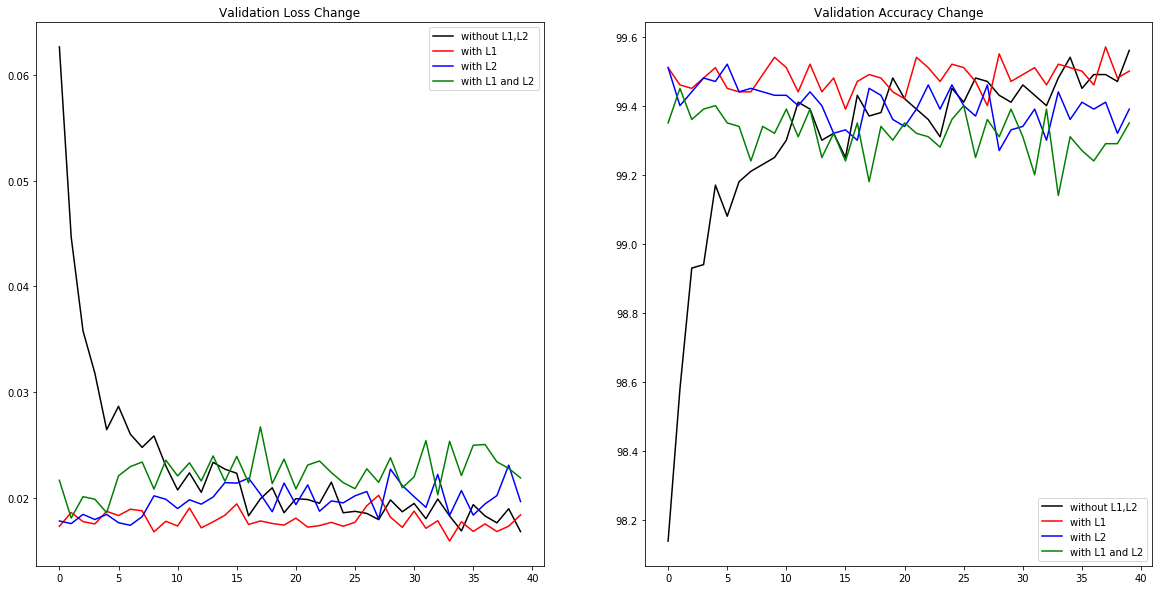

In [10]:
# Let's visualize what the plot displays
import matplotlib.pyplot as plt 
fig, axs = plt.subplots(1,2,figsize=(20,10))


axs[0].plot(test_losses,color='black',label='without L1,L2')
axs[0].plot(test_losses_l1,color='red',label='with L1 ')
axs[0].plot(test_losses_l2,color='blue',label='with L2')
axs[0].plot(test_losses_l1_l2,color='green',label='with L1 and L2')
axs[0].set_title("Validation Loss Change")
axs[0].legend(loc="upper right")

axs[1].plot(test_acc,color='black',label='without L1,L2')
axs[1].plot(test_acc_l1,color='red',label='with L1 ')
axs[1].plot(test_acc_l2,color='blue',label='with L2 ')
axs[1].plot(test_acc_l1_l2,color='green',label='with L1 and L2')
axs[1].set_title("Validation Accuracy Change")
axs[1].legend(loc="lower right")


Misclassified images 



1 [ Predicted Value: 9, Actual Value: 7 ]


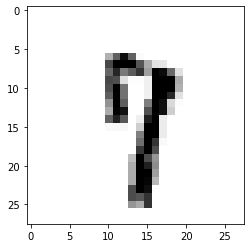



2 [ Predicted Value: 9, Actual Value: 4 ]


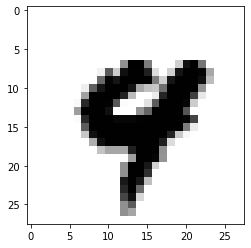



3 [ Predicted Value: 9, Actual Value: 4 ]


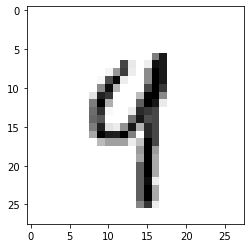



4 [ Predicted Value: 7, Actual Value: 2 ]


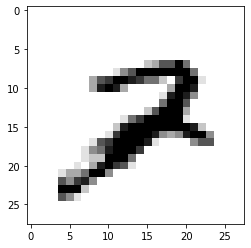



5 [ Predicted Value: 3, Actual Value: 5 ]


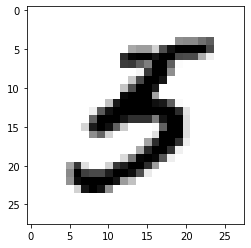



6 [ Predicted Value: 7, Actual Value: 5 ]


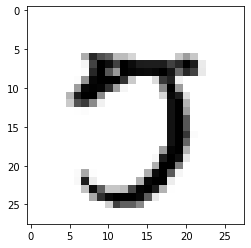



7 [ Predicted Value: 7, Actual Value: 0 ]


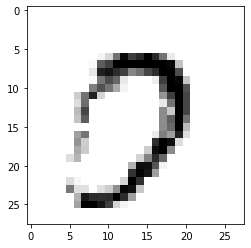



8 [ Predicted Value: 9, Actual Value: 4 ]


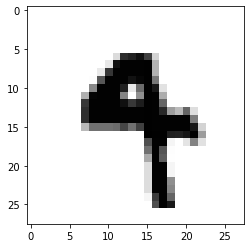



9 [ Predicted Value: 0, Actual Value: 2 ]


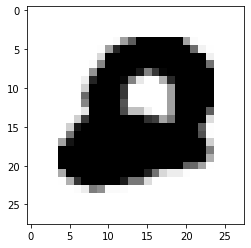



10 [ Predicted Value: 8, Actual Value: 3 ]


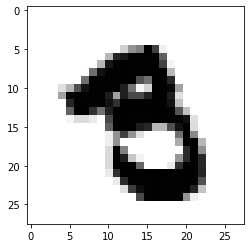



11 [ Predicted Value: 9, Actual Value: 4 ]


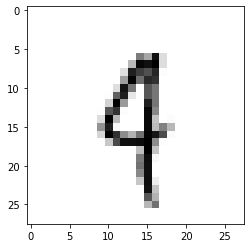



12 [ Predicted Value: 1, Actual Value: 6 ]


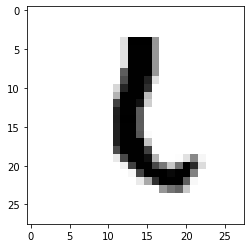



13 [ Predicted Value: 8, Actual Value: 9 ]


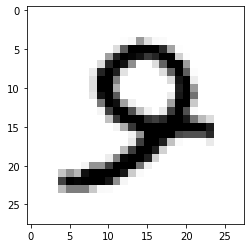



14 [ Predicted Value: 9, Actual Value: 4 ]


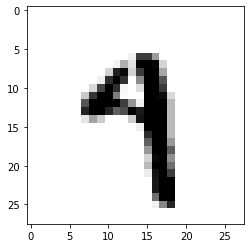



15 [ Predicted Value: 5, Actual Value: 9 ]


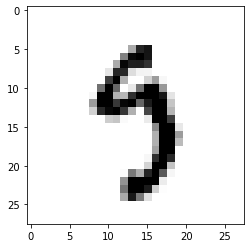



16 [ Predicted Value: 1, Actual Value: 7 ]


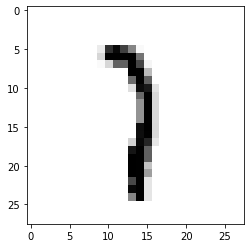



17 [ Predicted Value: 0, Actual Value: 6 ]


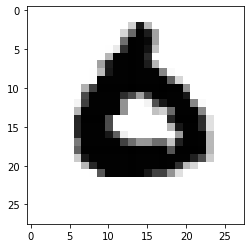



18 [ Predicted Value: 3, Actual Value: 1 ]


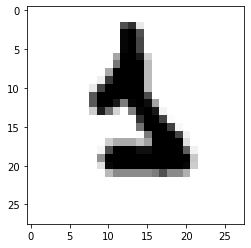



19 [ Predicted Value: 3, Actual Value: 5 ]


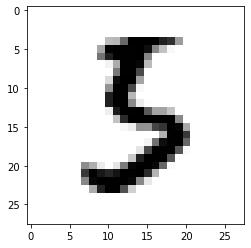



20 [ Predicted Value: 2, Actual Value: 7 ]


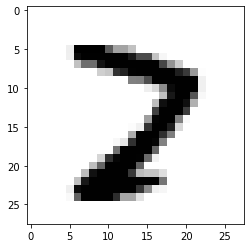



21 [ Predicted Value: 1, Actual Value: 7 ]


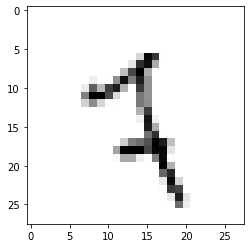



22 [ Predicted Value: 2, Actual Value: 7 ]


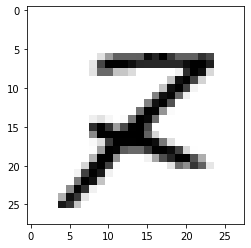



23 [ Predicted Value: 5, Actual Value: 6 ]


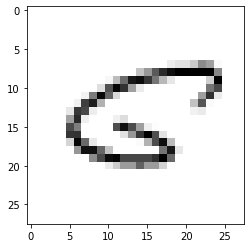



24 [ Predicted Value: 6, Actual Value: 5 ]


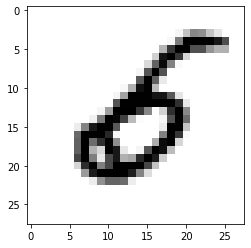



25 [ Predicted Value: 3, Actual Value: 5 ]


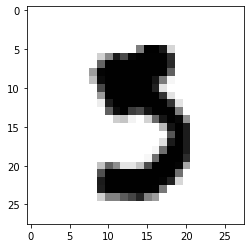



26 [ Predicted Value: 6, Actual Value: 1 ]


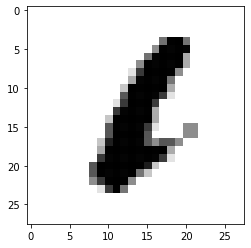



27 [ Predicted Value: 4, Actual Value: 9 ]


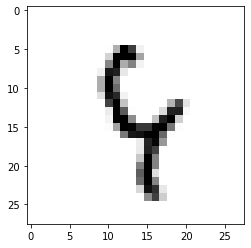



28 [ Predicted Value: 4, Actual Value: 9 ]


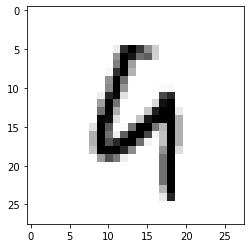



29 [ Predicted Value: 6, Actual Value: 0 ]


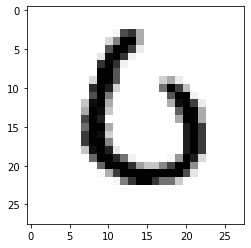



30 [ Predicted Value: 1, Actual Value: 6 ]


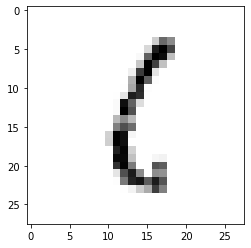



31 [ Predicted Value: 1, Actual Value: 6 ]


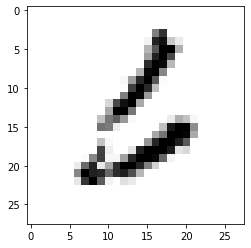



32 [ Predicted Value: 1, Actual Value: 8 ]


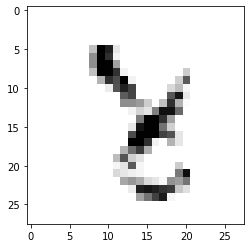



33 [ Predicted Value: 2, Actual Value: 7 ]


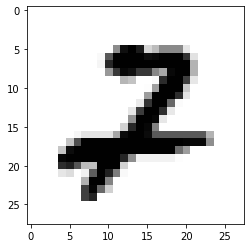



34 [ Predicted Value: 9, Actual Value: 4 ]


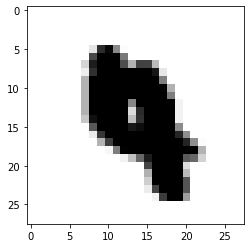



35 [ Predicted Value: 1, Actual Value: 7 ]


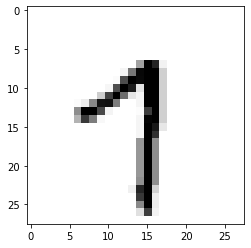



36 [ Predicted Value: 9, Actual Value: 4 ]


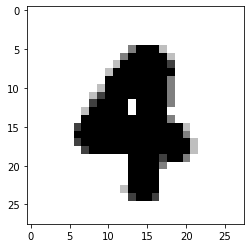



37 [ Predicted Value: 3, Actual Value: 5 ]


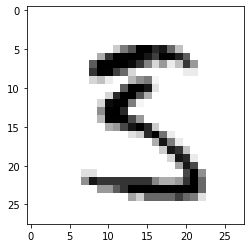



38 [ Predicted Value: 5, Actual Value: 8 ]


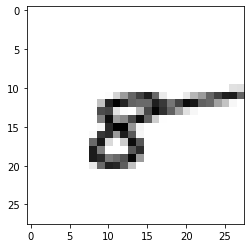



39 [ Predicted Value: 2, Actual Value: 3 ]


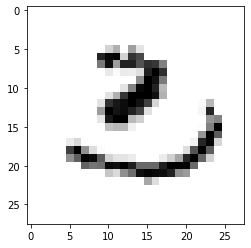



40 [ Predicted Value: 7, Actual Value: 9 ]


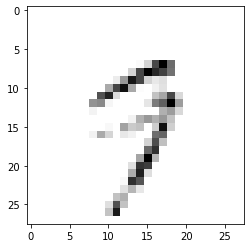



41 [ Predicted Value: 1, Actual Value: 7 ]


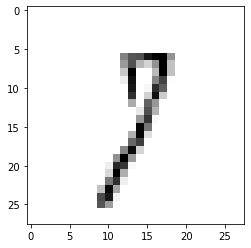



42 [ Predicted Value: 5, Actual Value: 3 ]


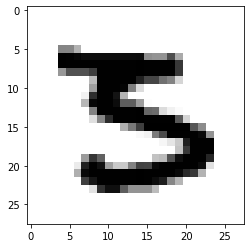



43 [ Predicted Value: 2, Actual Value: 7 ]


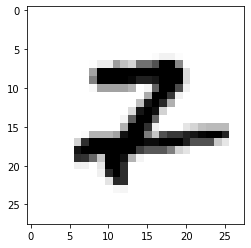



44 [ Predicted Value: 4, Actual Value: 9 ]


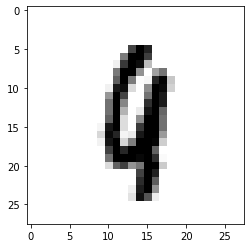



45 [ Predicted Value: 9, Actual Value: 4 ]


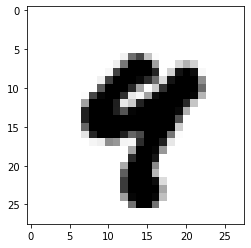



46 [ Predicted Value: 2, Actual Value: 1 ]


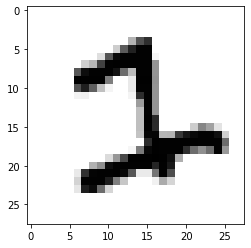



47 [ Predicted Value: 0, Actual Value: 8 ]


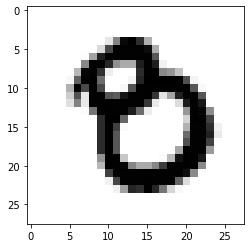



48 [ Predicted Value: 7, Actual Value: 2 ]


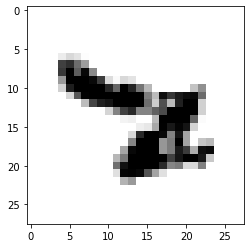



49 [ Predicted Value: 1, Actual Value: 7 ]


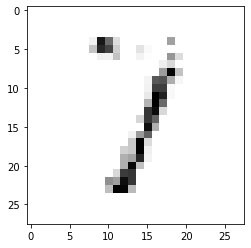



50 [ Predicted Value: 2, Actual Value: 4 ]


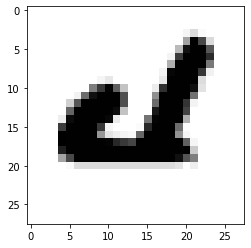



51 [ Predicted Value: 3, Actual Value: 1 ]


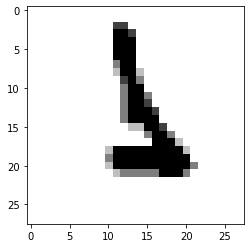



52 [ Predicted Value: 9, Actual Value: 8 ]


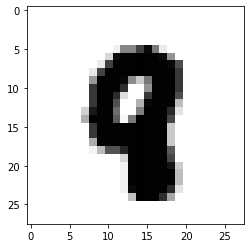



53 [ Predicted Value: 6, Actual Value: 9 ]


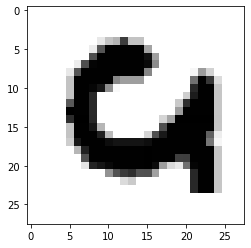



54 [ Predicted Value: 9, Actual Value: 4 ]


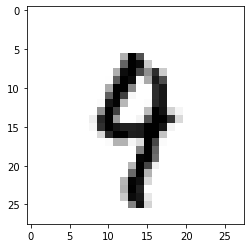



55 [ Predicted Value: 3, Actual Value: 5 ]


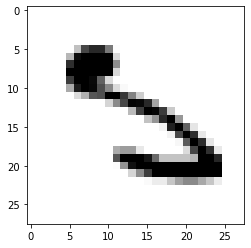



56 [ Predicted Value: 0, Actual Value: 9 ]


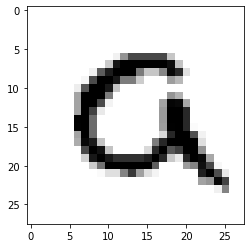



57 [ Predicted Value: 2, Actual Value: 8 ]


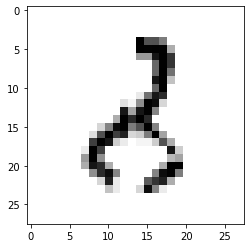



58 [ Predicted Value: 0, Actual Value: 6 ]


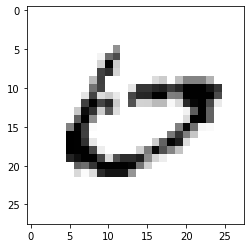



59 [ Predicted Value: 7, Actual Value: 9 ]


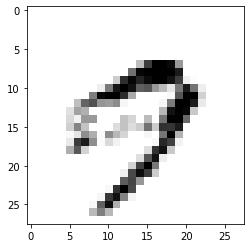



60 [ Predicted Value: 3, Actual Value: 8 ]


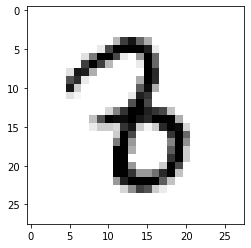



61 [ Predicted Value: 3, Actual Value: 7 ]


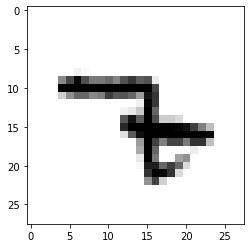



62 [ Predicted Value: 3, Actual Value: 1 ]


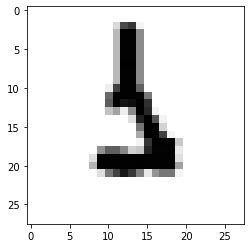



63 [ Predicted Value: 5, Actual Value: 3 ]


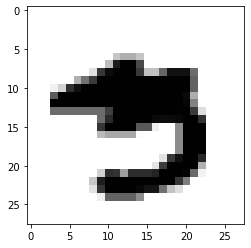



64 [ Predicted Value: 1, Actual Value: 6 ]


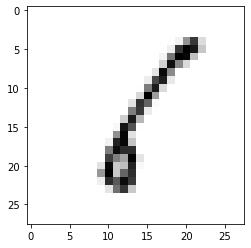



65 [ Predicted Value: 2, Actual Value: 7 ]


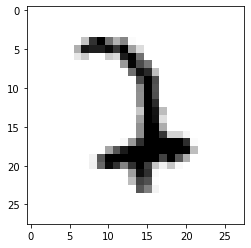

In [11]:
%matplotlib inline

def miscImages(model, device, test_loader):
    model.eval()
    test_loss = 0
    incorrect = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability

            for i in range(len(target)):
              if pred[i].item() != target[i]:
                incorrect += 1
                print('\n\n{} [ Predicted Value: {}, Actual Value: {} ]'.format(
                incorrect, pred[i].item(), target[i], ))
                plt.imshow(data[i].cpu().numpy().squeeze(), cmap='gray_r')
                plt.show()

miscImages(model, device, test_loader)